In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime
import gzip
import matplotlib.gridspec as gridspec

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from methods.raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D

import methods.xflib as xflib

xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/WIPP_stencils/python/methods/libxformd.so')

R2D = 180./np.pi
D2R = np.pi/180.
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [274]:
infile = '../outputs/stencils/nightside/stencil_testing/phi_inlat_35_AE8MAX.pklz'

with gzip.open(infile,'rb') as file:
    data = pickle.load(file)

['phi_N_full', 'phi_S_sum', 'phi_N_sum', 'params', 'phi_S_full']
['E_tot_arr', 'Lshells', 'tvec', 'Emin', 'Emax', 'n_JL', 'NUM_E', 'E_EXP_TOP', 'fluxfile', 'E_EXP_BOT', 'flux_dist', 'dt', 'v_tot_arr', 'alpha_dist', 'n_JE', 'DE_EXP']
(58, 512, 1001)
6.2
(1000,) (512,)


<IPython.core.display.Javascript object>


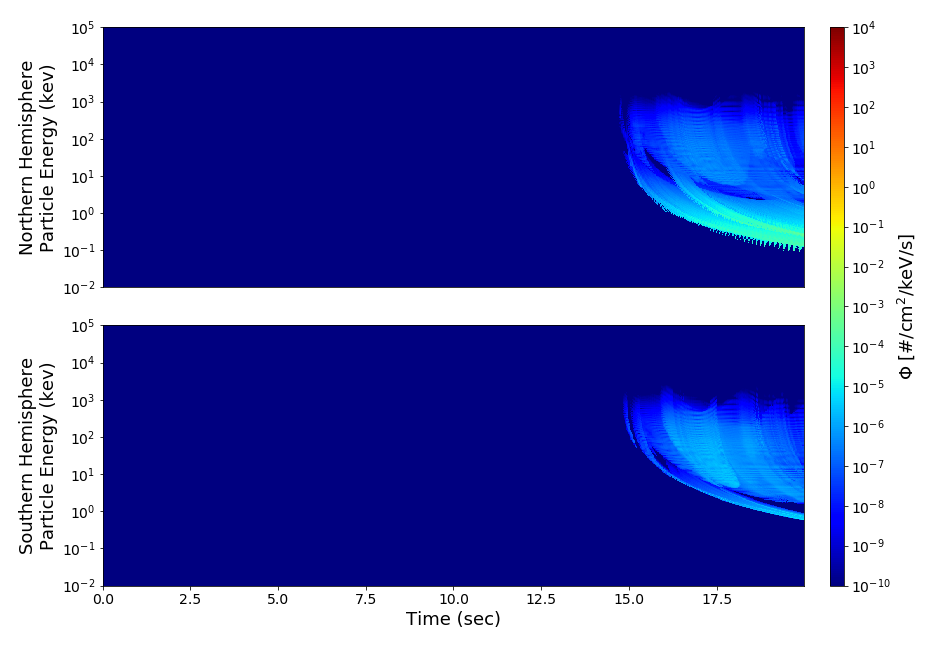

-3.43541133693 -100.0


In [224]:
print data.keys()

ev2joule = (1.60217657)*1e-19 # Joules / ev
joule2millierg = 10*1e10 


# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------
# print data.keys()
phi_N = data['phi_N_full']
phi_S = data['phi_S_full']
Lshells = data['params']['Lshells']
tvec    = data['params']['tvec']
evec    = data['params']['E_tot_arr']

print data['params'].keys()
print np.shape(phi_N)
L_ind = 50
print Lshells[L_ind]

clims = [-10, 4]
print np.shape(tvec), np.shape(evec)

fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1, 0.02])
print gs
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
cbax = plt.subplot(gs[:,-1])
cmap = plt.get_cmap('jet')


Ndata = np.log10(phi_N[L_ind,:,:-1])
Ndata[np.isinf(Ndata)] = -100
print np.max(Ndata), np.min(Ndata)
Sdata = np.log10(phi_S[L_ind,:,:-1])
Sdata[np.isinf(Sdata)] = -100
# print np.max(Sdata), np.min(Sdata)
p0 = ax0.pcolormesh(tvec, np.log10(evec/1000.), Ndata, vmin = clims[0], vmax=clims[1], cmap = cmap)
p1 = ax1.pcolormesh(tvec, np.log10(evec/1000.), Sdata, vmin = clims[0], vmax=clims[1], cmap = cmap)

ax0.set_xticks([])
ytix = ax0.get_yticks()
yticklabels = ['$10^{%d}$'%k for k in ytix]
ax0.set_yticklabels(yticklabels)
ytix = ax1.get_yticks()
yticklabels = ['$10^{%d}$'%k for k in ytix]
ax1.set_yticklabels(yticklabels)

ax0.set_ylabel('Northern Hemisphere\nParticle Energy (kev)')
ax1.set_ylabel('Southern Hemisphere\nParticle Energy (kev)')
ax1.set_xlabel('Time (sec)')

cb = plt.colorbar(p0, cax=cbax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('$\Delta \\alpha_{RMS}$ (deg)')
cb.set_label('$\Phi$ [#/cm$^2$/keV/s]')

# ax0.set_title('Phi: In lat = %g deg, L = %g'%(Lshells[L_ind])
fig.tight_layout()

# ax[0].pcolormesh(Ndata, origin='lower',interpolation='none')



['E_tot_arr', 'Lshells', 'tvec', 'Emin', 'Emax', 'n_JL', 'NUM_E', 'E_EXP_TOP', 'fluxfile', 'E_EXP_BOT', 'flux_dist', 'dt', 'v_tot_arr', 'alpha_dist', 'n_JE', 'DE_EXP']


<IPython.core.display.Javascript object>


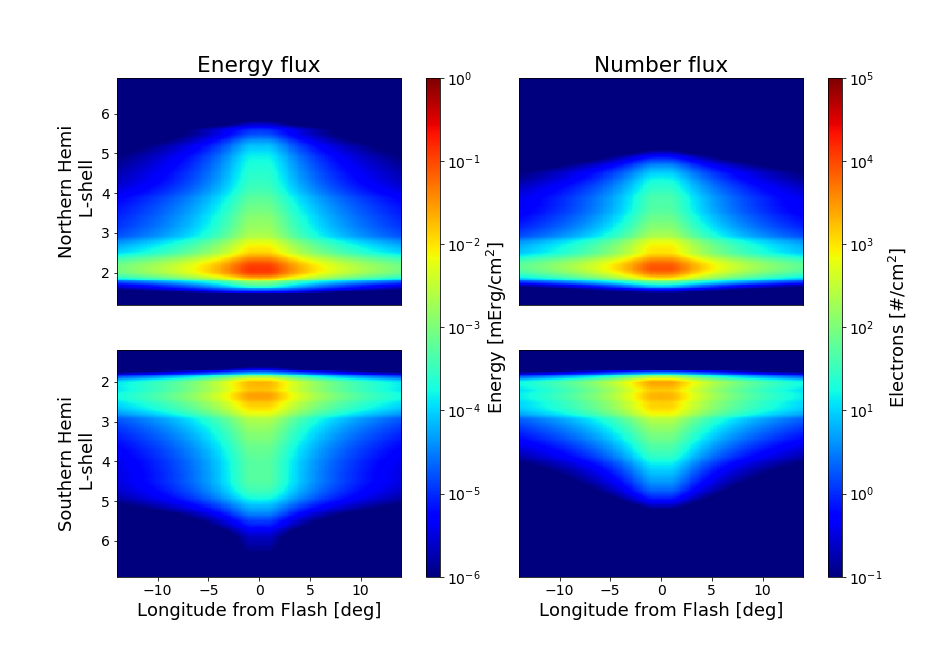

In [282]:
# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 8
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# Hotspot maps vs longitude and L-shell:
Qlims = [-6,0]
Nlims = [-1,5]
num_lons = np.shape(Ntotal)[1]
dlon = 1
lon_max = num_lons - 1
lon_axis = np.linspace(-lon_max, lon_max, 2*num_lons - 1)
L_axis = data['params']['Lshells']
dl = 0.5


# L_axis = np.arange(1.2, 7, 0.2)
L_interp   = np.linspace(L_axis[0], L_axis[-1], 200)
# L_interp = L_axis
lon_interp = np.linspace(lon_axis[0], lon_axis[-1], 200)


# First -- integrate phi to get N (number flux) or E

ev2joule = (1.60217657)*1e-19 # Joules / ev
joule2millierg = 10*1e10
# print data['params']['E_tot_arr']

print data['params'].keys()

# Energy vector, in ev
E = data['params']['E_tot_arr']
DE_EXP = data['params']['DE_EXP']
E_EXP_BOT = data['params']['E_EXP_BOT']
E_EXP_TOP = data['params']['E_EXP_TOP']
dt = data['params']['dt']

#  Energy differential term dE, in kev
DE = np.exp(np.linspace(1,len(E),len(E))*DE_EXP/np.log10(np.e))
DE = DE*DE_EXP/np.log10(np.e)
DE = DE*(1e-3)*np.power(10, E_EXP_BOT + DE_EXP/2.)

# Integrate over each energy bin
QN = data['phi_N_sum']*(E*DE)[np.newaxis,np.newaxis,:]*ev2joule*joule2millierg*dt
NN = data['phi_N_sum']*(DE)[np.newaxis,np.newaxis,:]*dt
QS = data['phi_S_sum']*(E*DE)[np.newaxis,np.newaxis,:]*ev2joule*joule2millierg*dt
NS = data['phi_S_sum']*(DE)[np.newaxis,np.newaxis,:]*dt



# Sum over energy bins
NNtotal = np.sum(NN,axis=-1) # counts/cm^2, total for flash
QNtotal = np.sum(QN,axis=-1) # mErg/cm^2, total for flash
NStotal = np.sum(NS,axis=-1) # counts/cm^2, total for flash
QStotal = np.sum(QS,axis=-1) # mErg/cm^2, total for flash

def interp_stencil(D):
    D2 = np.hstack([np.fliplr(D)[:,0:-1], D])  # Flip left - right
    interp = interpolate.RegularGridInterpolator([Lshells, lon_axis],D2)
    px, py = np.meshgrid(lon_interp, L_interp)
    pts = zip(py.ravel(), px.ravel())
    D_interp = np.log10(interp(pts)).reshape(len(L_interp), len(lon_interp))
    D_interp[np.isinf(D_interp)] = -100
    return D_interp

N_N_stencil = interp_stencil(NNtotal)
Q_N_stencil = interp_stencil(QNtotal)
N_S_stencil = interp_stencil(NStotal)
Q_S_stencil = interp_stencil(QStotal)


cmap = plt.get_cmap('jet')
fig = plt.figure()
gs = gridspec.GridSpec(2,5, width_ratios=[1, 0.05, 0.1, 1, 0.05])
axQN = plt.subplot(gs[0,0])
axQS = plt.subplot(gs[1,0])
axNN = plt.subplot(gs[0,3])
axNS = plt.subplot(gs[1,3])
cbQ  = plt.subplot(gs[:,1])
cbN  = plt.subplot(gs[:,4])
# ax.imshow(np.hstack([np.fliplr(Ntotal)[:,0:-1], Ntotal]))

pQN = axQN.pcolorfast(lon_interp, L_interp, Q_N_stencil, vmin=Qlims[0], vmax=Qlims[1], cmap=cmap)
pQS = axQS.pcolorfast(lon_interp, L_interp, Q_S_stencil, vmin=Qlims[0], vmax=Qlims[1], cmap=cmap)
cQ = plt.colorbar(pQN, cax=cbQ)

pNN = axNN.pcolorfast(lon_interp, L_interp, N_N_stencil, vmin=Nlims[0], vmax=Nlims[1],  cmap=cmap)
pNS = axNS.pcolorfast(lon_interp, L_interp, N_S_stencil, vmin=Nlims[0], vmax=Nlims[1],  cmap=cmap)
cN = plt.colorbar(pNN, cax=cbN)

axQS.invert_yaxis()
axNS.invert_yaxis()
# Title the columns
axQN.set_title('Energy flux')
axNN.set_title('Number flux')
# Hide y axes on right column:
axNN.set_yticks([])
axNS.set_yticks([])
axQN.set_xticks([])
axNN.set_xticks([])

cticks = np.arange(Qlims[0],Qlims[1] + 1)
cQ.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cQ.set_ticklabels(cticklabels)
cQ.set_label('Energy [mErg/cm$^2$]')

cticks = np.arange(Nlims[0],Nlims[1] + 1)
cN.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cN.set_ticklabels(cticklabels)
cN.set_label('Electrons [#/cm$^2$]')



axQN.set_ylabel('Northern Hemi\n L-shell')
axQS.set_ylabel('Southern Hemi\n L-shell')
axQS.set_xlabel('Longitude from Flash [deg]')
axNS.set_xlabel('Longitude from Flash [deg]')

# fig.tight_layout()

(58, 29)


<IPython.core.display.Javascript object>


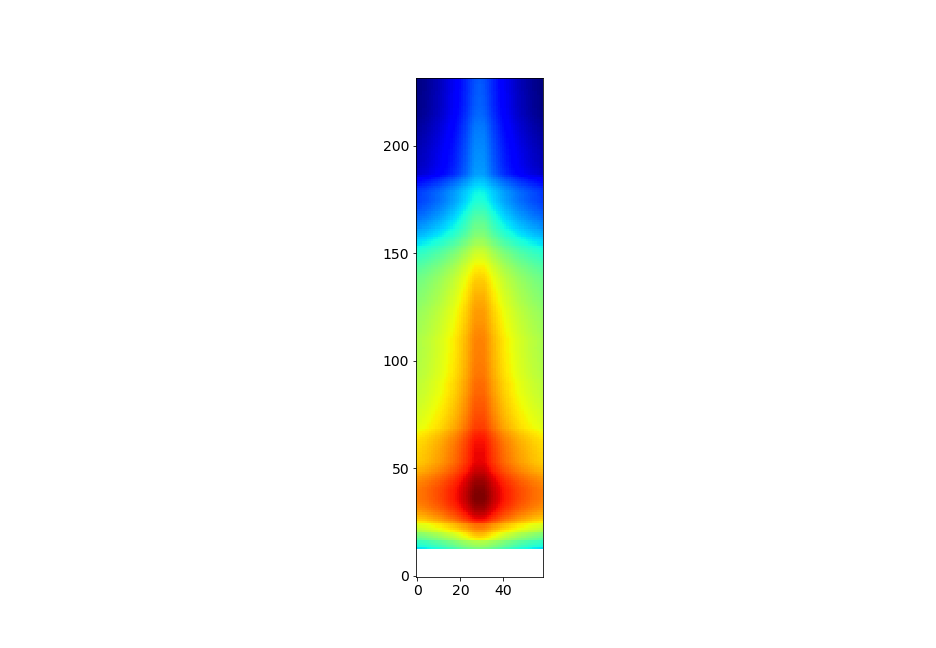

In [170]:
# Interpolate onto new axis:


def interp_2d(D):
    interp = interpolate.RegularGridInterpolator([Lshells, lon_axis],D)
    px, py = np.meshgrid(lon_interp, Linterp)
    pts = zip(py.ravel(), px.ravel())
    D_interp = np.log10(NNinterp(pts)).reshape(len(Linterp), len(lon_interp))
    D_interp[np.isinf(D_interp)] = -10-0


N = np.hstack([np.fliplr(NNtotal)[:,0:-1], NNtotal])
print np.shape(N)

NNinterp = interpolate.RegularGridInterpolator([Lshells, lon_axis], N)

# NNinterp = interpolate.RegularGridInterpolator((lon_axis, Lshells), np.hstack([np.fliplr(NNtotal)[:,0:-1], NNtotal]))

px, py = np.meshgrid(lon_interp, Linterp)
pts = zip(py.ravel(), px.ravel())

N_N_stencil = np.log10(NNinterp(pts)).reshape(len(Linterp), len(lon_interp))


plt.figure()
plt.imshow(N_N_stencil, origin='lower', cmap=cmap)

['E_tot_arr', 'Lshells', 'tvec', 'Emin', 'Emax', 'n_JL', 'NUM_E', 'E_EXP_TOP', 'fluxfile', 'E_EXP_BOT', 'flux_dist', 'dt', 'v_tot_arr', 'alpha_dist', 'n_JE', 'DE_EXP']
['phi_N_full', 'phi_S_sum', 'phi_N_sum', 'params', 'phi_S_full']
(58, 256, 1001)


<IPython.core.display.Javascript object>


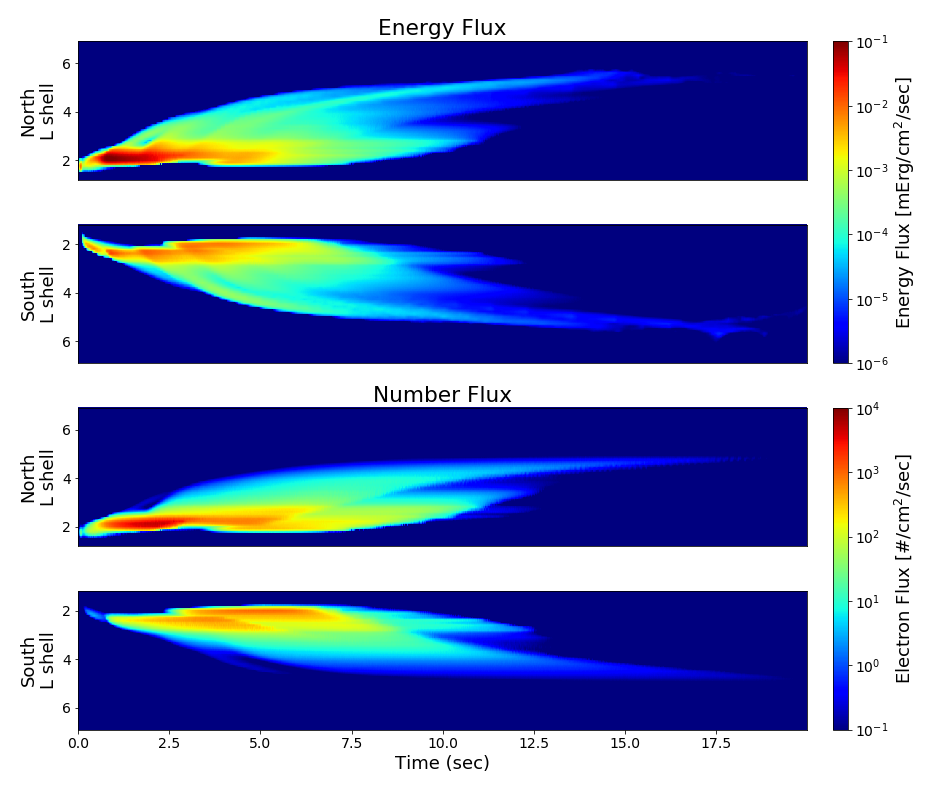

In [275]:
# Flux vs time vs L:

# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 10
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 18,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


ev2joule = (1.60217657)*1e-19 # Joules / ev
joule2millierg = 10*1e10
# print data['params']['E_tot_arr']

print data['params'].keys()
print data.keys()
# Energy vector, in ev
E = data['params']['E_tot_arr']
DE_EXP = data['params']['DE_EXP']
E_EXP_BOT = data['params']['E_EXP_BOT']
E_EXP_TOP = data['params']['E_EXP_TOP']
dt = data['params']['dt']

#  Energy differential term dE, in kev
DE = np.exp(np.linspace(1,len(E),len(E))*DE_EXP/np.log10(np.e))
DE = DE*DE_EXP/np.log10(np.e)
DE = DE*(1e-3)*np.power(10, E_EXP_BOT + DE_EXP/2.)

Qlims = [-6,-1]
Nlims = [-1,4]

tvec = data['params']['tvec']
Lvec = data['params']['Lshells']

t_interp = tvec
L_interp = np.linspace(Lvec[0], Lvec[-1],200)
# Phi_full ~ L x Energy x time
print np.shape(data['phi_N_full'])

QN = (np.sum(data['phi_N_full']*(E*DE)[np.newaxis, :, np.newaxis]*ev2joule*joule2millierg, axis=1) )
QS = (np.sum(data['phi_S_full']*(E*DE)[np.newaxis, :, np.newaxis]*ev2joule*joule2millierg, axis=1) )
NN = (np.sum(data['phi_N_full']*DE[np.newaxis, :, np.newaxis], axis=1) )
NS = (np.sum(data['phi_S_full']*DE[np.newaxis, :, np.newaxis], axis=1) )

def interp_timedomain(D):
    interp = interpolate.RegularGridInterpolator([Lvec, tvec],D)
    px, py = np.meshgrid(t_interp, L_interp)
    pts = zip(py.ravel(), px.ravel())
    D_interp = np.log10(interp(pts)).reshape(len(L_interp), len(t_interp))
    D_interp[np.isinf(D_interp)] = -100
    return D_interp

QN = interp_timedomain(QN[:,0:-1])
QS = interp_timedomain(QS[:,0:-1])
NN = interp_timedomain(NN[:,0:-1])
NS = interp_timedomain(NS[:,0:-1])


cmap = plt.get_cmap('jet')
fig = plt.figure()
gs = gridspec.GridSpec(4,2, width_ratios=[1, 0.02])
axQN = plt.subplot(gs[0,0])
axQS = plt.subplot(gs[1,0])
axNN = plt.subplot(gs[2,0])
axNS = plt.subplot(gs[3,0])
cbQ  = plt.subplot(gs[0:2,1])
cbN  = plt.subplot(gs[2:,1])

p0 = axQN.pcolorfast(t_interp, L_interp, QN, cmap=cmap, vmin=Qlims[0], vmax=Qlims[1])
p1 = axQS.pcolorfast(t_interp, L_interp, QS, cmap=cmap, vmin=Qlims[0], vmax=Qlims[1])
axQS.invert_yaxis()

cQ = plt.colorbar(p0, cax = cbQ)
cticks = np.arange(Qlims[0],Qlims[1] + 1)
cQ.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cQ.set_ticklabels(cticklabels)
cQ.set_label('Energy Flux [mErg/cm$^2$/sec]')

p2 = axNN.pcolorfast(t_interp, L_interp, NN, cmap=cmap, vmin=Nlims[0], vmax=Nlims[1])
p3 = axNS.pcolorfast(t_interp, L_interp, NS, cmap=cmap, vmin=Nlims[0], vmax=Nlims[1])
axNS.invert_yaxis()

cN = plt.colorbar(p2, cax = cbN)
cticks = np.arange(Nlims[0],Nlims[1] + 1)
cN.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cN.set_ticklabels(cticklabels)
cN.set_label('Electron Flux [#/cm$^2$/sec]')


axQN.set_xticks([])
axQS.set_xticks([])
axNN.set_xticks([])
axNS.set_xlabel('Time (sec)')

axQN.set_ylabel('North\nL shell')
axQS.set_ylabel('South\nL shell')
axNN.set_ylabel('North\nL shell')
axNS.set_ylabel('South\nL shell')

axQN.set_title('Energy Flux')
axNN.set_title('Number Flux')
fig.tight_layout()






In [271]:
modes_to_do = [('AE8MAX', 0),
               ('AE8MIN', 0),
               ('AE8MAX', 2)]

for (fluxfile_prefix, flux_dist) in modes_to_do:
    print flux_dist

0
0
2
